CNN and RNN Encoder - RNN Decoder - Word to Word - With Attention
====

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import io
import sys
import time
import os
import glob
import pickle
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu
from rouge import Rouge
sys.path.append('../data_collection/compiler')
from IPython.display import IFrame, Markdown
from Compiler import Compiler
from tempfile import NamedTemporaryFile
import importlib

AUTOTUNE = tf.data.experimental.AUTOTUNE

tf.config.experimental_run_functions_eagerly(True)
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
# Read a file and return a string
def load_doc(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

Data Transformation
----

In [3]:
dir_name = 'PIX2CODE_COMPILED'
data_dir = '../data_collection/webpages/' + dir_name

IMG_WIDTH = 299
IMG_HEIGHT = 299

# get all image filepaths
list_img = tf.data.Dataset.list_files(str(data_dir + "/*.png"), shuffle=False)

DATASET_SIZE = len(glob.glob(data_dir + "/*.png"))

# for f in list_img.take(5):
#     print(f.numpy())

**Image Processing**

In [4]:
# decodes an image string
@tf.function
def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_png(img, channels=3)
    
    img = tf.image.convert_image_dtype(img, tf.float32)
    
    img = tf.image.resize(img, (IMG_WIDTH, IMG_HEIGHT))
                          
    #img = tf.keras.applications.inception_v3.preprocess_input(img)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    # resize the image to the desired size.
    return img

**Sequence Processing**

In [5]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', split=" ", lower=False)
# Create the vocabulary 
tokenizer.fit_on_texts([load_doc('./DSL.vocab')])

# Add padding
tokenizer.word_index['<PAD>'] = 0
tokenizer.index_word[0] = '<PAD>'

In [6]:
def tokenizer_lookup(word):
    return tokenizer.word_index[word.numpy().decode()]

# tensorflow way to convert text to sequence with tokenizer
@tf.function
def text_to_seq(text, tokenizer):
    spl = tf.map_fn(lambda t: tf.py_function(func=tokenizer_lookup, inp=[t], Tout=tf.int32), text, dtype="int32")
    return spl

In [7]:
# converts image filepath to its label
@tf.function
def get_seq(file_path):
    # convert from png to gui file
    path = tf.strings.regex_replace(file_path, ".png", ".gui")
    # read contents and return
    label = tf.constant("<START> ") + tf.io.read_file(path) + tf.constant(" <END>")
    return tf.strings.split(label)

In [8]:
print(tokenizer.index_word)

{1: '{', 2: '}', 3: '<START>', 4: '<END>', 5: 'Body', 6: 'Block', 7: 'Container', 8: 'Row', 9: 'Column', 10: 'Header', 11: 'Footer', 12: 'Paragraph', 13: 'Image', 14: 'Button', 15: 'Subtitle', 16: 'Title', 17: 'Link', 18: 'TextBox', 19: 'CheckBox', 20: 'RadioBox', 21: 'Range', 0: '<PAD>'}


**Combine and Split Datasets**

In [9]:
# does all processing per dataset image path
@tf.function
def process_path(file_path):
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    
    seq = get_seq(file_path)
    seq = text_to_seq(seq, tokenizer)
    return img, seq

In [10]:
dataset = list_img.map(process_path, num_parallel_calls=AUTOTUNE)

In [11]:
max_length = dataset.map(lambda _, y: tf.size(y), num_parallel_calls=AUTOTUNE)
max_length = max_length.reduce(tf.constant(0), lambda x, y: tf.math.maximum(x, y))

Image shape:  (299, 299, 3)
Sequence:  ['<START> Body { Header { Button Link Link Link } Row { Column { Subtitle Paragraph Button } } Row { Column { Subtitle Paragraph Button } Column { Subtitle Paragraph Button } } Row { Column { Subtitle Paragraph Button } Column { Subtitle Paragraph Button } } } <END> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>']


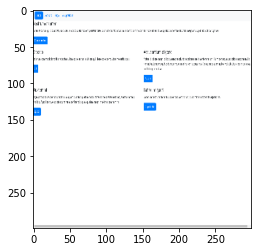

In [12]:
dataset = dataset.map(lambda x, y: (x, tf.concat([y, tf.repeat(0, max_length - tf.size(y))], -1)))

for image, seq in dataset.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Sequence: ", tokenizer.sequences_to_texts([seq.numpy()]))
    plt.imshow(image.numpy())

In [13]:
train_size = int(DATASET_SIZE * 0.7)
val_size = int(DATASET_SIZE * 0.1)
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size).take(val_size)
test_dataset = dataset.skip(train_size + val_size)

In [14]:
BATCH_SIZE = 8
BUFFER_SIZE = 50
embedding_dim = 16
encoder_units = 128
decoder_units = 256
num_steps = train_size // BATCH_SIZE
num_val_steps = val_size // BATCH_SIZE
vocab_size = len(tokenizer.word_index) + 1
seq_limit = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

Model Definition
----

In [15]:
class CNN_Encoder(tf.keras.Model):
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        self.model = tf.keras.models.Sequential()
        self.model.add(tf.keras.layers.Conv2D(16, (3, 3), padding='valid', activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3,)))
        self.model.add(tf.keras.layers.Conv2D(16, (3,3), activation='relu', padding='same', strides=2))
        self.model.add(tf.keras.layers.Dropout(0.2))
        self.model.add(tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'))
        self.model.add(tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', strides=2))
        self.model.add(tf.keras.layers.Dropout(0.2))
        self.model.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'))
        self.model.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', strides=2))
        self.model.add(tf.keras.layers.Dropout(0.2))
        self.model.add(tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'))

        self.model.add(tf.keras.layers.Dense(512, activation='relu'))
        self.model.add(tf.keras.layers.Dropout(0.2))
        self.out = tf.keras.layers.Dense(embedding_dim)
        
    def call(self, x):
        x = self.model(x)
        
        x = self.out(x)
        x = tf.reshape(x, (x.shape[0], -1, x.shape[3]))
        
        x = tf.nn.relu(x)
        
        return x

In [16]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

        # hidden shape == (batch_size, hidden_size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # score shape == (batch_size, 64, hidden_size)
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

        # attention_weights shape == (batch_size, 64, 1)
        # you get 1 at the last axis because you are applying score to self.V
        attention_weights = tf.nn.softmax(self.V(score), axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [17]:
class RNN_Encoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size, max_length):
        super(RNN_Encoder, self).__init__()
        self.units = units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.models.Sequential()
        self.gru.add(tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   dropout=0.2,
                                   recurrent_initializer='glorot_uniform'))
        self.gru.add(tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   dropout=0.2,
                                   recurrent_initializer='glorot_uniform'))
        self.gru.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units, activation='relu')))
        
    def call(self, x):
        x = self.embedding(x)
        
        x = self.gru(x)
        
        return x
        
    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [18]:
class CNN_RNN_Encoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size, max_length):
        super(CNN_RNN_Encoder, self).__init__()
        self.rnn = RNN_Encoder(embedding_dim, units, vocab_size, max_length)
        self.cnn = CNN_Encoder(embedding_dim)
        self.features = None
        
    def call(self, seq, img=None):
        if img is None and self.features is None:
            print("Error, img and features None")
            return
        elif img is not None:
            self.features = self.cnn(img)
             
        seq = self.rnn(seq)
        
        return self.features, seq
    
    def set_features(self, img):
        self.features = self.cnn(img)
    
    def reset_state(self, batch_size):
        return self.rnn.reset_state(batch_size)

In [19]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self, units, vocab_size, max_length):
        super(RNN_Decoder, self).__init__()
        self.units = units
        self.gru1 = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   dropout=0.2,
                                   recurrent_initializer='glorot_uniform')
        self.gru2 = tf.keras.layers.GRU(self.units,
                                   return_sequences=False,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
        
        self.fc = tf.keras.layers.Dense(units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)
        
        self.attention = BahdanauAttention(self.units)
        self.rep = tf.keras.layers.RepeatVector(1)
        
    def call(self, features, seq, hidden):
        context_vector, attention_weights = self.attention(features, hidden)
        
        feat = self.rep(context_vector)
        
        x = tf.keras.layers.concatenate([feat, seq])
        
        x, state = self.gru2(self.gru1(x))
        
        x = self.fc(x)
        x = self.fc2(x)
        
        return x, state, attention_weights
    
    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [20]:
class RNN_Encoder_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Encoder_Decoder, self).__init__()
        self.units = units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.models.Sequential()
        self.gru.add(tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   dropout=0.2,
                                   recurrent_initializer='glorot_uniform'))
        self.gru.add(tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   dropout=0.2,
                                   recurrent_initializer='glorot_uniform'))
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x, features, hidden):
        x = self.embedding(x)
    
        x = tf.concat([tf.expand_dims(features, 1), x], axis=-1)
        
        output, state = self.gru(x)

        x = self.fc1(output)

        x = tf.reshape(x, (-1, x.shape[2]))

        x = self.fc2(x)
        
        return x, state
    
    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [21]:
encoder = CNN_RNN_Encoder(embedding_dim, encoder_units, vocab_size, seq_limit)
decoder = RNN_Decoder(decoder_units, vocab_size, seq_limit)

In [22]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [23]:
checkpoint_path = "./checkpoints/cnnrnn_rnn_w2w_att/exp"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [24]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1]) * 5
    # restoring the latest checkpoint in checkpoint_path
    ckpt.restore(ckpt_manager.latest_checkpoint)

Model Training
----

In [25]:
def save_plot(plot_path, plot_list):
    with open(plot_path, 'wb') as fp:
        pickle.dump(plot_list, fp)
        
def load_plot(plot_path):
    with open(plot_path, 'rb') as fp:
         return pickle.load(fp)

In [26]:
# # adding this in a separate cell because if you run the training cell
# # many times, the loss_plot array will be reset
loss_plot = load_plot("./checkpoints/cnnrnn_rnn_w2w_att/exp/loss_plot")
val_plot = load_plot("./checkpoints/cnnrnn_rnn_w2w_att/exp/val_plot")
# loss_plot = []
# val_plot = []

In [27]:
@tf.function
def pad_tensor_sequence(seq):
    return tf.pad(seq, [[0, 0], [0, seq_limit - seq.shape[1]]], "CONSTANT")

In [28]:
@tf.function
def train_step(img_tensor, target, val=False):
    loss = 0

    # initializing the hidden state for each batch
    # because the captions are not related from image to image
    hidden = decoder.reset_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([tokenizer.word_index['<START>']] * target.shape[0], 1)
    
    if val:
        encoder.set_features(img_tensor)

        for i in range(1, target.shape[1]):
            features, seq = encoder(dec_input)
            # passing the features through the decoder
            predictions, hidden, _ = decoder(features, seq, hidden)

            loss += loss_function(target[:, i], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

        total_loss = (loss / int(target.shape[1]))
        return loss, total_loss

    with tf.GradientTape() as tape:
        encoder.set_features(img_tensor)

        for i in range(1, target.shape[1]):
            features, seq = encoder(dec_input)
            # passing the features through the decoder
            predictions, hidden, _ = decoder(features, seq, hidden)

            loss += loss_function(target[:, i], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

In [29]:
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0
    total_val_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 20 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
            epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
            print ('Time taken for Batches {} sec'.format(time.time() - start))
            
    for (batch, (img_tensor, target)) in enumerate(val_dataset):
        _, t_loss = train_step(img_tensor, target, True)
        total_val_loss += t_loss
        
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)
    val_plot.append(total_val_loss / num_val_steps)

    if (epoch + 1) % 5 == 0:
        ckpt_manager.save()

    print ('Epoch {} Loss {:.6f} Val Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps, total_val_loss/num_val_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 1.8206
Time taken for Batches 5.462965488433838 sec
Epoch 1 Batch 20 Loss 1.3040
Time taken for Batches 47.227964878082275 sec
Epoch 1 Batch 40 Loss 1.0397
Time taken for Batches 88.83099794387817 sec
Epoch 1 Batch 60 Loss 0.3829
Time taken for Batches 130.308735370636 sec
Epoch 1 Batch 80 Loss 0.3593
Time taken for Batches 171.69773864746094 sec
Epoch 1 Batch 100 Loss 0.3050
Time taken for Batches 213.3437762260437 sec
Epoch 1 Batch 120 Loss 0.2059
Time taken for Batches 254.68773436546326 sec
Epoch 1 Batch 140 Loss 0.2563
Time taken for Batches 295.8667359352112 sec
Epoch 1 Loss 0.608786 Val Loss 0.169109
Time taken for 1 epoch 357.8799409866333 sec

Epoch 2 Batch 0 Loss 0.1673
Time taken for Batches 2.912001609802246 sec
Epoch 2 Batch 20 Loss 0.1150
Time taken for Batches 44.6050341129303 sec
Epoch 2 Batch 40 Loss 0.0894
Time taken for Batches 85.94401335716248 sec
Epoch 2 Batch 60 Loss 0.1148
Time taken for Batches 128.26699900627136 sec
Epoch 2 Batch 80 Loss 0

Epoch 13 Batch 0 Loss 0.3713
Time taken for Batches 3.166032314300537 sec
Epoch 13 Batch 20 Loss 0.3061
Time taken for Batches 48.41510033607483 sec
Epoch 13 Batch 40 Loss 0.3561
Time taken for Batches 93.32628798484802 sec
Epoch 13 Batch 60 Loss 0.3331
Time taken for Batches 137.45735931396484 sec
Epoch 13 Batch 80 Loss 0.3284
Time taken for Batches 184.57027864456177 sec
Epoch 13 Batch 100 Loss 0.3443
Time taken for Batches 229.1223108768463 sec
Epoch 13 Batch 120 Loss 0.3034
Time taken for Batches 274.0883128643036 sec
Epoch 13 Batch 140 Loss 0.3057
Time taken for Batches 320.2495131492615 sec
Epoch 13 Loss 0.340550 Val Loss 0.334952
Time taken for 1 epoch 386.06111240386963 sec

Epoch 14 Batch 0 Loss 0.3229
Time taken for Batches 2.9039676189422607 sec
Epoch 14 Batch 20 Loss 0.3158
Time taken for Batches 45.0899658203125 sec
Epoch 14 Batch 40 Loss 0.3262
Time taken for Batches 87.37899160385132 sec
Epoch 14 Batch 60 Loss 0.3259
Time taken for Batches 130.90596866607666 sec
Epoch 14

Model Evaluation
----

In [28]:
save_plot("./checkpoints/cnnrnn_rnn_w2w_att/exp/loss_plot", loss_plot)
save_plot("./checkpoints/cnnrnn_rnn_w2w_att/exp/val_plot", val_plot)

In [28]:
def evaluate(image):
    attention_plot = np.zeros((max_length, 1444))
    
    hidden = decoder.reset_state(batch_size=1)

    encoder.set_features(tf.expand_dims(image, 0))

    dec_input = tf.expand_dims([tokenizer.word_index['<START>']], 0)
    result = ['<START>']

    for i in range(1, max_length):
        features, seq = encoder(dec_input)
        predictions, hidden, attention_weights = decoder(features, seq, hidden)
        
        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<END>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [29]:
def plot_attention(image, result, attention_plot, lim=None):
    fig = plt.figure(figsize=(10, 20))
    
    if lim is None or lim > len(result):
        lim = len(result)

    for l in range(lim):
        temp_att = np.resize(attention_plot[l], (38, 38))
        ax = fig.add_subplot(lim//2, lim//4, l+1)
        ax.set_title(result[l])
        img = ax.imshow(image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

In [30]:
def render_content_with_text(key, value):
    placeholder = "[]"
    if "Button" in key or "TextBox" in key or "Link" in key:
        value = value.replace(placeholder, "Curabitur")
    elif "Title" in key or "title" in key:
        value = value.replace(placeholder, "Aliquam erat")
    elif "Paragraph" in key:
        value = value.replace(placeholder, "Lorem ipsum dolor sit amet, consectetur adipiscing elit. Sed fringilla nisi a tellus aliquet cursus. Sed commodo magna at libero malesuada sodales. Aliquam sed tempor.")
    return value

In [31]:
def dsl_to_iframe(dsl, w=950, h=700):
    compiler = Compiler("../data_collection/compiler/web_dsl_mapping.json")
    dsl = '\n'.join(dsl).replace("<START>", "").replace("<END>", "").strip()
    dsl = dsl.replace("\n{", "{").split("\n")
    compiled = compiler.compile_string(dsl, rendering_function=render_content_with_text)
    f = NamedTemporaryFile(dir="./", delete=False, suffix='.html')
    f.write(compiled.encode())
    f.flush()
    f.close()
    display(IFrame(src=os.path.basename(f.name), width=w, height=h))
    time.sleep(0.5)
    os.unlink(f.name)

**Model Loss**

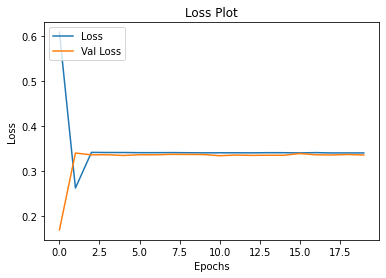

In [32]:
plt.plot(loss_plot)
plt.plot(val_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.legend(['Loss', 'Val Loss'], loc='upper left')
plt.show()

**Prediction Quality and Attention**

Actual DSL:  <START> Body { Header { Link Button Link Link } Row { Column { Subtitle Paragraph Button } Column { Subtitle Paragraph Button } } Row { Column { Subtitle Paragraph Button } Column { Subtitle Paragraph Button } Column { Subtitle Paragraph Button } Column { Subtitle Paragraph Button } } Row { Column { Subtitle Paragraph Button } Column { Subtitle Paragraph Button } } } <END>                        
Predicted DSL:  <START> Body { Column { Column { Column { Subtitle Paragraph Button } Row { Link } Column { Header { Column { Subtitle Paragraph Button } Column { Subtitle Paragraph Button } Row { Column { Subtitle Paragraph Button Link Link } Column { Subtitle Paragraph Button } } Row { Subtitle Paragraph Button } Column { Subtitle Paragraph Button } Column { Subtitle Paragraph Button Link Button } Column { Subtitle Paragraph Button } Column { Subtitle Paragraph Button } Column { Column { Subtitle Paragraph Button } <END>


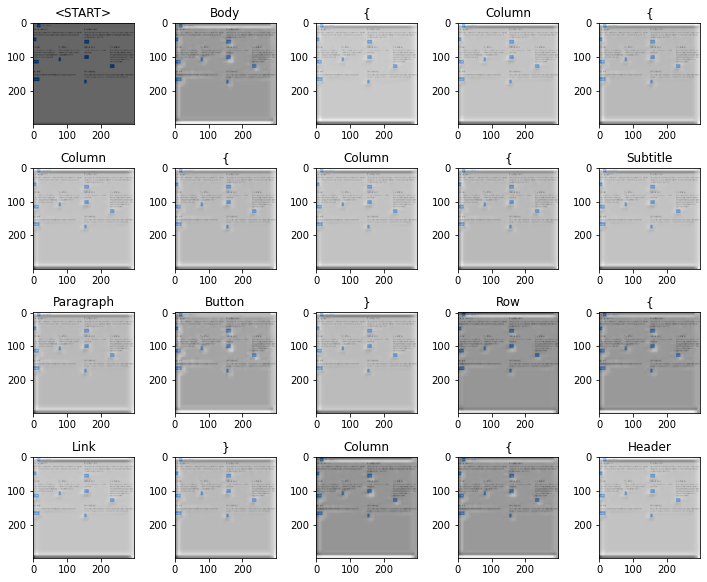

**Actual**

**Predicted**

In [33]:
test_entry = test_dataset.take(1)

for image, seq in test_entry:
    actual = tokenizer.sequences_to_texts([seq.numpy()])[0].replace("<PAD>", "")
    predicted, attention = evaluate(image)
    predicted = ' '.join(predicted)
    print("Actual DSL: ", actual)
    print("Predicted DSL: ", predicted)
    plot_attention(image.numpy(), predicted.split(), attention, 20)
    display(Markdown('**Actual**'))
    dsl_to_iframe(actual.split())
    display(Markdown('**Predicted**'))
    dsl_to_iframe(predicted.split())

**Calculate BLEU Metric**

In [34]:
def score(dataset, verbose=False):
    actual, predicted = list(), list()
    i = 0
    for image, seq in dataset:
        act = tokenizer.sequences_to_texts([seq.numpy()])[0].replace("<PAD>", "").split()
        pred, _ = evaluate(image)
        pred = ["<START>"] + pred
        if verbose:
            print("\n\nActual DSL---->\n", act)
            print("\nPredicted DSL---->\n", pred)
        else:
            print("Predicted count: " + str(i + 1), end='\r', flush=True)
        actual.append([act])
        predicted.append(pred)
        i += 1
    bleu = corpus_bleu(actual, predicted)
    
    _actual = list(map(lambda p: ' '.join(p[0]), actual))
    _predicted = list(map(lambda p: ' '.join(p), predicted))
    _rouge = Rouge()
    rouge = _rouge.get_scores(_predicted, _actual, avg=True)
    return bleu, rouge,  actual, predicted
        
bleu, rouge, actual, predicted = score(test_dataset)

In [35]:
print(bleu)
print(rouge)

0.48506370471640675
{'rouge-1': {'f': 0.6452207433584074, 'p': 0.8425631511005696, 'r': 0.6278362351218074}, 'rouge-2': {'f': 0.6077783283760563, 'p': 0.8060333834923373, 'r': 0.5911744756004415}, 'rouge-l': {'f': 0.8574748637560506, 'p': 0.929592352092352, 'r': 0.8016666666666661}}
